# AEROSP 536 Electric Propulsion: Homework 2
Jason Chen

## Problem 1
### Part (a)
We are given a table of different electric propulsion thruster types, along with their range of specific impulses, powers, and efficiencies. We know that for a given low thrust trajectory characterized by $\Delta v$ and $\Delta t$, the performance metrics can be related by (as derived in lecture):
$$
\Delta t = t_T = \frac{m_D (I_{sp}g_0)^2}{2 \eta P_{in}} \left( e^{\Delta v/I_{sp}g_0} - 1 \right)
$$
where $m_D$ is the dry mass of the spacecraft and can be expressed as the sum of payload, structural, and power supply mass:
$$
m_D = m_{PL} + m_S + m_{PS}
$$
Finally note that power can be expressed here as a specific mass density $\alpha$:
$$
\alpha = \frac{m_{PS}}{P_{in}} = \textrm{ 25 kg/kW}
$$
Let's assume that the structural mass is zero $m_S = 0$ because ideally the power system also acts as the spacecraft structure, and because there is no information given regarding it. This means we can rearrange the first equation:
$$
\Delta t = \frac{(m_{PL} + \alpha P_{in}) (I_{sp}g_0)^2}{2 \eta P_{in}} \left( e^{\Delta v/I_{sp}g_0} - 1 \right)
$$
$$
m_{PL} = \frac{2 \eta P_{in} \Delta t}{\left(e^{\Delta v/I_{sp}g_0} - 1 \right)(I_{sp}g_0)^2} - \alpha P_{in}
$$
And we will plot this below.

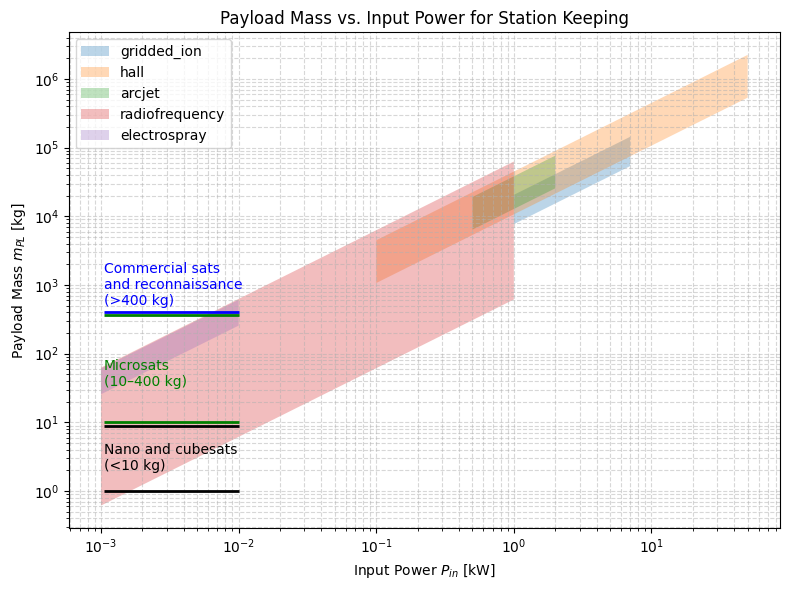

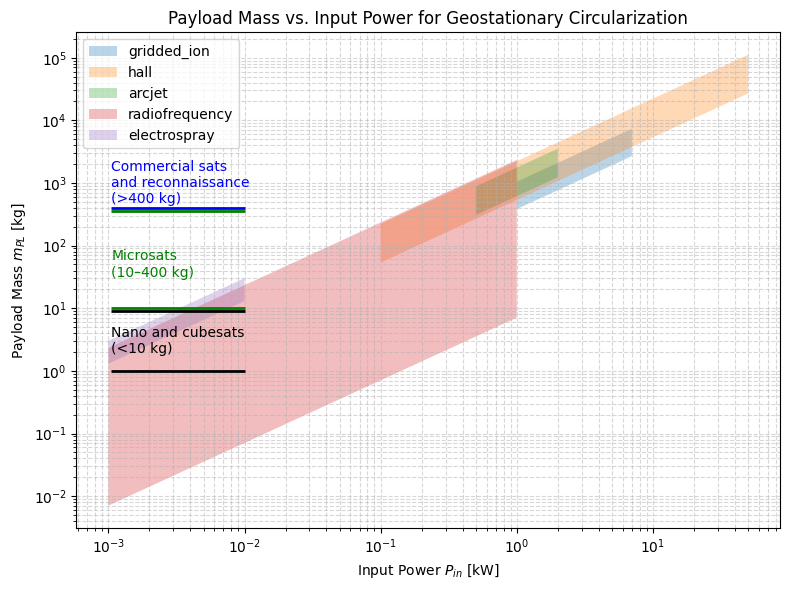

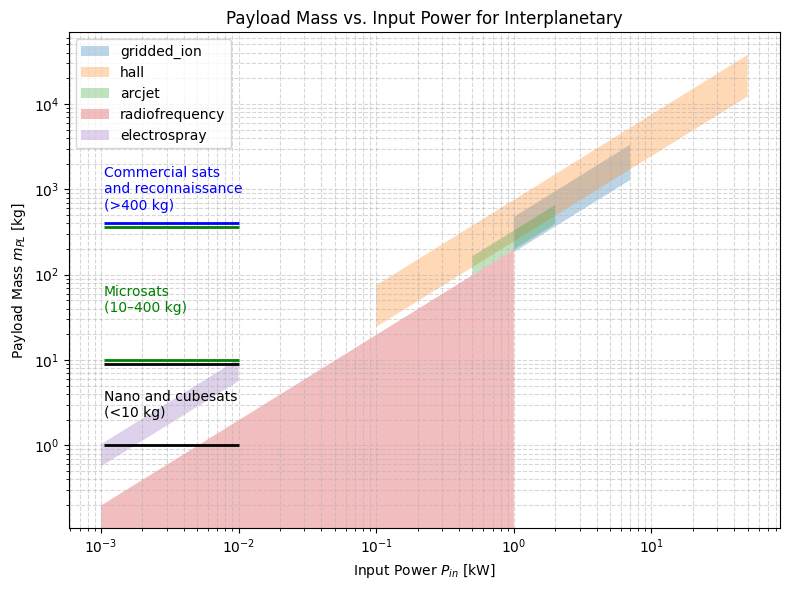

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pint import UnitRegistry
ureg = UnitRegistry(auto_reduce_dimensions=True)
Q_ = ureg.Quantity

missions = {
    'station_keeping': (Q_(100, 'm/s'), Q_(1, 'year')),
    'geostationary circularization': (Q_(1.4, 'km/s'), Q_(9, 'months')),
    'interplanetary': (Q_(10, 'km/s'), Q_(3, 'years'))
}
thrusters = {
    "gridded_ion":    {"isp": (2500, 5000), "P_in": (1.0, 7.0),    "eta": (0.60, 0.80)},
    "hall":           {"isp": (1000, 3000), "P_in": (0.1, 50.0),   "eta": (0.50, 0.70)},
    "arcjet":         {"isp": (500, 1000),  "P_in": (0.5, 2.0),    "eta": (0.20, 0.30)},
    "radiofrequency": {"isp": (200, 1000),  "P_in": (0.001, 1.0),  "eta": (0.01, 0.20)},
    "electrospray":   {"isp": (1000, 2000), "P_in": (0.001, 0.01), "eta": (0.80, 0.95)},
}
alpha = Q_(25, 'kg/kW').magnitude
g0 = 9.81

for mission_name, (delta_v, delta_t) in missions.items():
    delta_v = delta_v.to('m/s').magnitude
    delta_t = delta_t.to('s').magnitude
    plt.figure(figsize=(8, 6))

    for thruster, params in thrusters.items():
        isp_min, isp_max = params['isp']
        P_in_min, P_in_max = params['P_in']
        eta_min, eta_max = params['eta']

        # Create meshgrid for P_in and Isp
        P_in_vals = np.logspace(np.log10(P_in_min), np.log10(P_in_max), 100)  # kW
        isp_vals = np.array([isp_min, isp_max])
        eta_vals = np.array([eta_min, eta_max])

        # Calculate m_PL for all corners of the parameter space
        m_PL = np.zeros((2, 2, len(P_in_vals)))
        for i, isp in enumerate(isp_vals):
            for j, eta in enumerate(eta_vals):
                exp_term = np.exp(delta_v / (isp * g0)) - 1
                denom = exp_term * (isp * g0) ** 2
                m_PL[j, i, :] = ((2 * eta * P_in_vals * 1e3 * delta_t) / denom) - (alpha * P_in_vals)

        # Find min/max payload mass for each P_in
        m_PL_min = np.min(m_PL.reshape(-1, len(P_in_vals)), axis=0)
        m_PL_max = np.max(m_PL.reshape(-1, len(P_in_vals)), axis=0)

        plt.fill_between(P_in_vals, m_PL_min, m_PL_max, alpha=0.3, label=thruster)

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Input Power $P_{in}$ [kW]')
    plt.ylabel('Payload Mass $m_{PL}$ [kg]')
    plt.title(f'Payload Mass vs. Input Power for {mission_name.replace("_", " ").title()}')
    plt.hlines(1, P_in_vals[2], P_in_vals[-1], colors='black', linestyles='-', linewidth=2)
    plt.hlines(9, P_in_vals[2], P_in_vals[-1], colors='black', linestyles='-', linewidth=2)
    plt.hlines(10, P_in_vals[2], P_in_vals[-1], colors='green', linestyles='-', linewidth=2)
    plt.hlines(360, P_in_vals[2], P_in_vals[-1], colors='green', linestyles='-', linewidth=2)
    plt.hlines(400, P_in_vals[2], P_in_vals[-1], colors='blue', linestyles='-', linewidth=2)
    plt.text(P_in_vals[2], 3, "Nano and cubesats\n(<10 kg)", va='center', ha='left', fontsize=10, color='black')
    plt.text(P_in_vals[2], 50, "Microsats\n(10–400 kg)", va='center', ha='left', fontsize=10, color='green')
    plt.text(P_in_vals[2], 1000, "Commercial sats\nand reconnaissance\n(>400 kg)", va='center', ha='left', fontsize=10, color='blue')
    plt.legend()
    plt.grid(True, which='both', ls='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

### Part (b)
Hall thrusters are becoming the dominant form of electric propulsion because they have the highest ceiling of payload mass deliverable, and generally are extremely competitive when considering payload mass for a given input power above 1 kW (which is a reasonable size for a power supply on microsats and commercial satellites), only losing out narrowly to RF in stationkeeping. Additionally, as power supply technology inevitably improves and becomes lighter, hall thrusters are able to utilize that extra input power to deliver more payload mass. This is true for all domains of EP, as shown above in the previous 3 graphs.

### Part (c)

For the GTO transfer, the launch mass (i.e. wet mass of the entire system) for the given problem statement can be found via the equation we already have for dry mass, and then using the rocket equation to find the wet mass required at the beginning of the mission.

In [2]:
delta_v = missions['geostationary circularization'][0].m_as('m/s')
delta_t = missions['geostationary circularization'][1].m_as('s')
isp, eta, P_in = 2000, 0.7, 5
exp_term = np.exp(delta_v / (isp * g0)) - 1
denom = exp_term * (isp * g0) ** 2
m_dry = ((2 * eta * P_in * 1e3 * delta_t) / denom)
m_wet = m_dry * np.exp(delta_v / (isp * g0))
print(f"Launch mass for GTO transfer: {m_dry*1e-3:.2f} tonnes")

Launch mass for GTO transfer: 5.82 tonnes


### Part (d)

For chemical systems, the amount of kinetic energy available within the chemical bonds of the propellant is related to total enthalpy, which is called specific energy here:
$$
v_e = \sqrt{2 \eta h_0}
$$
where $v_e$ is the effective exhaust velocity, and is related to the specific impulse through $v_e = I_{sp} g_0$. With this, we can plug back into the rocket equation (noting this is an impulsive maneuver and therefore do not need to integrate) and we get the dry mass of the vehicle. Since this is a chemical system, there is no significant power system contribution to total mass, and to keep the comparison consistent, we will not consider the structural mass of the vehicle. Therefore, the dry mass is simply the paylaod mass $m_{PL}$.

In [3]:
delta_v = 1.36e3
h0_hydrolox, eta_hydrolox = 20e6, 0.3
h0_hydrazine, eta_hydrazine = 2e6, 0.1
v_hydrolox = np.sqrt(2 * eta_hydrolox * h0_hydrolox)
v_hydrazine = np.sqrt(2 * eta_hydrazine * h0_hydrazine)
print(f"Payload mass for LH2/LOX: {m_wet * np.exp(-delta_v/v_hydrolox):.2f} kg")
print(f"Payload mass for Hydrazine: {m_wet * np.exp(-delta_v/v_hydrazine):.2f} kg")

Payload mass for LH2/LOX: 4220.22 kg
Payload mass for Hydrazine: 727.70 kg


## Problem 2

### Part (a)

Specific final mass of the system is defined as:
$$
\alpha_f = \frac{m_f}{P_{in}}
$$
We are also given the relationship between transit time and $\Delta v$ for a Mars trajectory. Thus, given a transit time, we will have a $\Delta v$ requirement, and from this the only unknowns are now the input power and dry mass (since the problem statement gives us $I_{sp}$ and $\eta$):
$$
t_T = \frac{m_D (I_{sp}g_0)^2}{2 \eta P_{in}} \left( e^{\Delta v/I_{sp}g_0} - 1 \right)
$$
Since we defined the "final mass" as the delivered mass, it is equivalent to the dry mass (includes power supply, payload, and structural mass). So we can rearrange the equation:
$$
\alpha_f = \frac{2 \eta t_T}{(I_{sp}g_0)^2 \left( e^{\Delta v/I_{sp}g_0} - 1 \right)}
$$

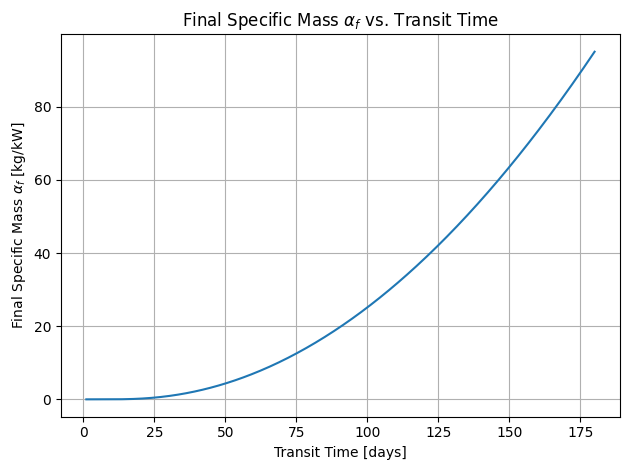

In [13]:
transit_times = np.linspace(1, 180, 500)  # [days]
delta_v = (1250/transit_times + 90/(transit_times**2)) * 1e3  # [m/s]
isp, eta = 2000, 0.5
t_T = transit_times * 24 * 3600  # [s]
alpha_f = ((2*eta*t_T) / (((isp*g0)**2) * (np.exp(delta_v/(isp*g0)) - 1))) * 1e3  # [kg/kW]
plt.figure()
plt.plot(transit_times, alpha_f)
plt.xlabel('Transit Time [days]')
plt.ylabel(r'Final Specific Mass $\alpha_f$ [kg/kW]')
plt.title(r'Final Specific Mass $\alpha_f$ vs. Transit Time')
plt.grid(True)
plt.tight_layout()
plt.show()

### Part (b)

Given that $\alpha_{PS} = 10 \textrm{ kg/kW}$ and assuming that the dry mass is 100% the power supply system $\alpha_{PS} = m_{D}/P_{in} = \alpha_{f}$, the fastest transit time that can be achieved can be found by:
$$
t_T = \frac{\alpha_{PS} (I_{sp}g_0)^2}{2 \eta} \left( e^{\Delta v/I_{sp}g_0} - 1 \right)
$$
Or, we can simply sample the data we've already found above for $\alpha_{PS} = 10 \textrm{ kg/kW}$.

In [ ]:
print(f"Fastest transit time achievable for nuclear EP: {transit_times[np.argmin(np.abs(alpha_f - 10))]:.1f} days")

Fastest transit time achievable for nuclear: 68.4 days


We can see that this is significantly shorter than the Hohmann transfer time of 260 days, but is idealistic in that it assumes essentially no other dry mass on the vehicle. Additionally, it is not leaving time for the required deceleration burn.

### Part (c)

Assuming we have a nuclear EP mission with $t_T = 200 \textrm{ days}$ and $m_{PL} = 50,000 \textrm{ kg}$, we can find the required power input as:
$$
t_T = \frac{(m_{PL} + \alpha_{PS}P_{in}) (I_{sp}g_0)^2}{2 \eta P_{in}} \left( e^{\Delta v/I_{sp}g_0} - 1 \right)
$$
$$
P_{in} = m_{PL} \left( \frac{t_T 2 \eta}{(I_{sp}g0)^2 \left( e^{\Delta v/I_{sp}g_0} - 1 \right)} - \alpha_{PS} \right)^{-1}
$$

In [19]:
delta_v = (1250/200 + 90/(200**2)) * 1e3  # [m/s]
t_T = 200 * 24 * 3600  # [s]
p_in = 50000 * ((t_T * 2 * eta) / ((isp*g0)**2 * (np.exp(delta_v/(isp*g0))-1)) - 10/1e3) ** -1
print(f"Required power input for 200 day transit with 50,000 kg payload: {p_in/1e3:.1f} kW")

Required power input for 200 day transit with 50,000 kg payload: 456.2 kW


### Part (d)

Assuming we can deliver 50,000 kg per launch, we need to find the wet mass of the LEO to Mars mission to determine the number of launches from Earth necessary. 

We will assume the 200 day transit requirement and thus we can solve directly for the dry mass. Using the rocket equation again (which will not consider the gravity drag of the Sun, but is adequate for this estimate), we can get the wet mass of the transfer vehicle. 

In [22]:
m_wet = (50000 + 10 * p_in/1e3) * np.exp(delta_v/(isp*g0))
print(f"Wet mass for transfer vehicle: {m_wet:.2f} kg")
print(f"Number of launches required: {int(np.ceil(m_wet/50000))}")

Wet mass for transfer vehicle: 75038.14 kg
Number of launches required: 2


### Part (e)

We can repeat the process for chemical rockets, using the rocket equation.

In [23]:
delta_v, isp = 7e3, 400
m_wet = 50000 * np.exp(delta_v/(isp*g0))
print(f"Wet mass for transfer vehicle: {m_wet:.2f} kg")
print(f"Number of launches required: {int(np.ceil(m_wet/50000))}")

Wet mass for transfer vehicle: 297649.61 kg
Number of launches required: 6


### Part (f)

Comparing the architectures, there's a nontrivial trade depending on the assumptions made on current technology. Purely based of the number of launches and assumming all else equal, EP is a clear winner. Due to the long distance between Earth and Mars, the EP system can beat the chemical system in both mass fraction or transit time, depending on what is held constant. However, there is the element of complexity of designing and flying a half-megawatt nuclear reactor in space to be adequately reliable and safe. This engineering effort may or may not be more difficult than 4 more launches, depending on the reliability of the launch vehicle. There is also the element of in-space assembly as well.

Overall, based on mass, I would choose the EP system, but a clearer answer can be made given more information on the involved technologies.

## Problem 3
### Part (a)
The $\Delta v$ for a low thrust trajectory from the quasi-circular approximation from lecture is:
$$
\Delta v_{LT} = \sqrt{\frac{\mu}{r_0}} - \sqrt{\frac{\mu}{r_1}}
$$
For a Hohmann transfer, we get:
$$
\Delta v_{H} = \sqrt{\frac{\mu}{r_0}} \left( \sqrt{\frac{2r_1}{r_0+r_1}-1} \right) + \sqrt{\frac{\mu}{r_1}} \left( \sqrt{1-\frac{2r_0}{r_0+r_1}} \right)
$$
Plugging in:

In [ ]:
r0, r1, mu = 6570e3, 42164e3, 3.986e14
delta_v_lt = np.sqrt(mu/r0) - np.sqrt(mu/r1)
delta_v_h = np.sqrt(mu/r0) * (np.sqrt(2*r1/(r0+r1)) - 1) + np.sqrt(mu/r1) * (1 - np.sqrt(2*r0/(r0+r1)))
print(f"Delta-V for low-thrust transfer: {delta_v_lt:.1f} m/s")
print(f"Delta-V for Hohmann transfer: {delta_v_h:.1f} m/s")

Delta-v for low-thrust transfer: 4714.41 m/s
Delta-v for Hohmann transfer: 3935.08 m/s


We can see numerically that $\Delta v_{LT} > \Delta v_H$. This is apparent when considering the Oberth effect, which states that the most energy-efficient way to increase $\Delta v$ is at the fastest point in an orbit (at periapsis), which is achievable for the impulsive maneuver. However for the low-thrust maneuver, we are continuously thrusting as we spiral outwards. Additionally, the sprial trajectory is fighting gravity drag for a lot longer, while the impulsive maneuver is by definition essentially instant.

### Part (b)

We can simply use the rocket equation here since the payload mass is assumed to be the dry mass:
$$
\frac{m_D}{m_w} = e^{-\Delta v/(I_{sp}g_0)}
$$

In [30]:
isp_lt, isp_h = 2000, 300
payload_fraction_lt = np.exp(-delta_v_lt/(isp_lt*g0))
payload_fraction_h = np.exp(-delta_v_h/(isp_h*g0))
print(f"Payload fraction for low-thrust transfer: {payload_fraction_lt:.3f}")
print(f"Payload fraction for Hohmann transfer: {payload_fraction_h:.3f}")

Payload fraction for low-thrust transfer: 0.786
Payload fraction for Hohmann transfer: 0.263


The payload fraction is higher for the low-thrust trajectory because the degree of gain in $I_{sp}$ is much higher than the increased requirement of $\Delta v$ (the former increases by ~7x, while the latter increases by less than 2x). This is idealized in the sense that the power system usually has a high mass penalty in EP systems, but in reality this is relatively accurate in more mass can be delivered with EP systems but at the cost of higher transit time.

## Problem 4
### Part (a)



## Problem 6
### Part (a)

We start with the rocket equation, and substituting the known expressions given above for the dry mass $m_D$:
$$
\frac{m_D}{m_w} = e^{-\Delta v/(I_{sp}g_0)} = \frac{\left( \frac{t_B P_{in}}{\epsilon} \right) + m_{PL}}{m_w}
$$
$$
\frac{m_{PL}}{m_w} = e^{-\Delta v/(I_{sp}g_0)} - \frac{t_B P_{in}}{\epsilon m_w}
$$

Next, we'll substitute in a rearranged expression for power-specific thrust, and knowing the $m_p = \dot{m} t_B$ where $m_P$ is the mass of propellant:
$$
\frac{T}{P_{in}} = \frac{2\eta}{I_{sp}g_0} \Rightarrow P_{in} = \frac{\dot{m}(I_{sp}g_0)^2}{2\eta}
$$
So:
$$
\frac{m_{PL}}{m_w} = e^{-\Delta v/(I_{sp}g_0)} - \frac{\left( \frac{m_p}{\dot{m}} \right) \left( \frac{\dot{m}(I_{sp}g_0)^2}{2\eta} \right)}{\epsilon m_w} = e^{-\Delta v/(I_{sp}g_0)} - \left( \frac{(I_{sp}g_0)^2}{2\eta\epsilon} \right) \left( \frac{m_p}{m_w} \right)
$$

Finally, we can note that:
$$
\frac{m_p}{m_w} = \frac{m_w - m_D}{m_w} = 1-\frac{m_D}{m_w} = 1-e^{-\Delta v/(I_{sp}g_0)}
$$
And so substituting in:
$$
\boxed{\frac{m_{PL}}{m_w} = e^{-\Delta v/(I_{sp}g_0)} - \left( \frac{(I_{sp}g_0)^2}{2\eta\epsilon} \right) \left( 1-e^{-\Delta v/(I_{sp}g_0)} \right)}
$$

### Part (b)
Let's plot in Python the expression we derived above:

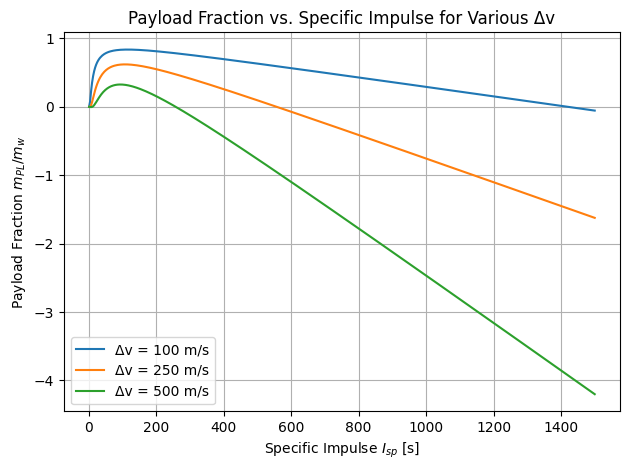

In [31]:
epsilon = 1e6  # 1 MJ/kg in J/kg
eta, g0 = 0.7, 9.81
isp_range = np.linspace(1, 1500, 500)
delta_vs = [100, 250, 500]

plt.figure()
for delta_v in delta_vs:
    exp_term = np.exp(-delta_v / (isp_range * g0))
    payload_frac = exp_term - ((isp_range * g0)**2 / (2 * eta * epsilon)) * (1 - exp_term)
    plt.plot(isp_range, payload_frac, label=f'Δv = {delta_v} m/s')

plt.xlabel('Specific Impulse $I_{sp}$ [s]')
plt.ylabel('Payload Fraction $m_{PL}/m_w$')
plt.title('Payload Fraction vs. Specific Impulse for Various Δv')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Part (c)

The reason there is an optimum payload fraction is because of how $I_{sp}$ and power system mass are related.

At low $I_{sp}$, it's trivial that the payload fraction is low because the exhaust velocity being too low drives a high amount of propellant mass. However at high $I_{sp}$, more input power is required for a fixed thrust and efficiency (it is proportional to exhaust velocity squared). And so higher input power requirement for a given energy density will drive up $m_{PS}$, which negatively affects the payload fraction (and it grows faster than the benefit of higher $I_{sp}$ due to the square). Thus, at high $I_{sp}$ the payload fraction drops.

Thus, between these two extremes, there must qualitatively be an optimum.

### Part (d)
We will find the optimum for each curve with `np.max()`:

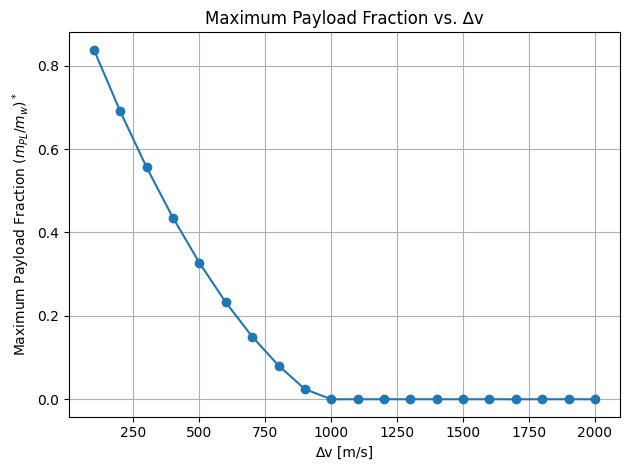

In [32]:
delta_v_range = np.arange(100, 2001, 100)
isp_range = np.linspace(1, 1500, 500)
max_payload_frac = []

for delta_v in delta_v_range:
    exp_term = np.exp(-delta_v / (isp_range * g0))
    payload_frac = exp_term - ((isp_range * g0)**2 / (2 * eta * epsilon)) * (1 - exp_term)
    max_payload_frac.append(np.max(payload_frac))

plt.figure()
plt.plot(delta_v_range, max_payload_frac, marker='o')
plt.xlabel('∆v [m/s]')
plt.ylabel('Maximum Payload Fraction $(m_{PL}/m_w)^*$')
plt.title('Maximum Payload Fraction vs. ∆v')
plt.grid(True)
plt.tight_layout()
plt.show()

Looking at this plot, the maximum possible $\Delta v$ appears to be around 1 km/s.

### Part (e)
An advantage of a battery storage system is that at the current energy density provided, for low $\Delta v$ maneuvers, it can provide amazing payload fractions (nearly 60% of the total mass of a spacecraft being the payload is a big win, at 250 m/s of $\Delta v$). This makes sense since the mass of a battery is much less than a nuclear reactor or large solar array, but the issue is that it cannot be recharged and thus there is a hard limit on the total energy that is deliverable to the EP system and therefore the deliverable $\Delta v$. Thus, we can see that if energy density is improved, the graph above will move to the right but will still be capped at a certain $\Delta v$ budget.

### Part (f)

Higher power levels means higher energy in the system and therefore larger energy dissipation systems. For example, to actually push megawatts of power nearly instantaneously to a thruster, the electronic components will need to be large, the chamber itself will likely need to be cooled to deal with waste heat (or direct heat from the propellant depending on EP architecture), and the radiators for the system will need to be large. Not to mention, the battery itself will need mounting and protection.